# Extended Kalman Filter (EKF)

## Requisitos

In [24]:
import pandas as pd
import numpy as np

import scipy
import scipy.linalg
from scipy import stats
from scipy.stats import norm

import sympy
from sympy import init_printing
from sympy.utilities.codegen import codegen
from sympy import Symbol, symbols, Matrix, sin, cos

import webbrowser #hiperlink
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
init_printing(use_latex=True)

## Projeto cinemático do modelo uniciclo (CTRV)

![](uniciclo.png)

### Vetor de estados de entrada

-Heading  (Orientação do veículo no eixo z)

-Yaw Rate (Rotação no eixo z)

$$ \mathbf{x} = \begin{bmatrix} x \\ y \\ \theta \end{bmatrix} = \begin{bmatrix} \text{Posição no eixo x} \\ \text{Posição no eixo y} \\ \text{Orientação do veículo no eixo z} \end{bmatrix} $$

### Vetor de controle de entrada

$$ \mathbf{u}_{k} = \begin{bmatrix} v \\ \psi \end{bmatrix} = \begin{bmatrix} \text{Velocidade linear} \\ \text{Rotação no eixo z} \end{bmatrix} $$

## Sistema dinâmico não-linear a ser rastreado

$$ \mathbf{x}_{k} = \mathbf{f}(\mathbf{x}_{k-1}, \mathbf{u}_k) + w_k + \tau_k $$

### Ruído nos vetores de estado e controle

Ruídos são variáveis aleatórias com normal de média nula, sendo a influência dos ruídos filtrada pelas covariâncias. É a solução estocástica ótima!

$$ w_k = \mathcal{N}(0, Q) $$

$$ \tau_k = \mathcal{N}(0, M) $$

## Sistema linearizado por série de Taylor

O sistema não-linear estocástico pode ser linearizado e descrito por meio de equações cinemáticas:

$$ \mathbf{x}_k = \begin{bmatrix} x_k \\ y_k \\ \theta_k \end{bmatrix} \implies \mathbf{x}_{k} = \begin{bmatrix} x_{k-1} \\ y_{k-1} \\ \theta_{k-1} \end{bmatrix} +  \begin{bmatrix} v_{k}\cdot\cos(\theta_{k-1})\cdot \Delta t \\ v_{k}\cdot\sin(\theta_{k-1})\cdot \Delta t \\ \psi_{k}\cdot \Delta t \end{bmatrix} $$

Para facilitar as operações foi adotado a seguinte notação:

$$ \mathbf{f}(x_{k-1}, u_k) = \begin{bmatrix} f_1 \\ f_2 \\ f_3 \end{bmatrix} = \begin{bmatrix} x_{k-1} + v_{k}\cdot\cos(\theta_{k-1})\cdot \Delta t \\ y_{k-1} + v_{k}\cdot\sin(\theta_{k-1})\cdot \Delta t \\ \theta_{k-1} + \psi_{k}\cdot \Delta t \end{bmatrix}$$

$\mathbf{F}_k$ é a matriz Jacobiana de $f(x_{k-1}, u_k)$ com relação ao vetor de estados.

$$
\mathbf{F}_k = \frac{\partial f(x_{k-1}, u_k)}{\partial x_{k-1}} \implies \mathbf{F}_k = \begin{bmatrix}
\frac{\partial f_1}{\partial x} & 
\frac{\partial f_1}{\partial y} &
\frac{\partial f_1}{\partial \theta}\\
\frac{\partial f_2}{\partial x} & 
\frac{\partial f_2}{\partial y} &
\frac{\partial f_2}{\partial \theta} \\
\frac{\partial f_3}{\partial x} & 
\frac{\partial f_3}{\partial y} &
\frac{\partial f_3}{\partial \theta}
\end{bmatrix}
$$

$$\mathbf{F}_k =\begin{bmatrix}
1 & 
0 &
-v_{k}\cdot\sin(\theta_{k-1})\cdot \Delta t \\
0 & 
1 &
v_{k}\cdot\cos(\theta_{k-1})\cdot \Delta t \\
0 & 
0 &
1
\end{bmatrix}
$$

$\mathbf{G}_k$ é a matriz Jacobiana de $f(x_{k-1}, u_k)$ com relação ao vetor de controle.

$$\mathbf{G}_k = \frac{\partial f(x_{k-1}, u_{k})}{\partial u_{k}} \implies \mathbf{G}_k = \begin{bmatrix}
\frac{\partial f_1}{\partial v} & \frac{\partial f_1}{\partial \psi} \\
\frac{\partial f_2}{\partial v} & \frac{\partial f_2}{\partial \psi} \\
\frac{\partial f_3}{\partial v} & \frac{\partial f_3}{\partial \psi}
\end{bmatrix}$$

$$\mathbf{G}_k = \begin{bmatrix}
\cos(\theta_{k-1})\cdot \Delta t & 0 \\
\sin(\theta_{k-1})\cdot \Delta t & 0 \\
0 & \Delta t
\end{bmatrix}$$

## Matriz de covariância de ruídos do sistema de posições

$$\mathbf{Q} = \begin{bmatrix}
\sigma_{x}^{2} & 0 & 0\\
0 & \sigma_{y}^{2} & 0\\
0 & 0 & \sigma_{\theta}^{2}
\end{bmatrix}$$

## Matriz de covariância de ruídos dos sinais de controle de movimento

Controle de erro nas variáveis de entrada $v$ e $\psi$ convertido em controle de erro nas variáveis de estado $x$, $y$ e $\theta$.

$$\mathbf M = \begin{bmatrix}
\sigma_{v}^{2} & 0 \\
0 & 
\sigma_{\psi}^{2}
\end{bmatrix}
$$

## Matriz de covariância de estado 

Associa-se a origem do veículo.

-Certeza da origem:

$$\mathbf{P} = \begin{bmatrix}
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0
\end{bmatrix}$$

-Valor arbitrado razoável (o filtro consegue corrigir em execução):

$$\mathbf{P} = \mathbf{Q} $$

-Valor arbitrado pelo professor:

$$\mathbf{P} = \begin{bmatrix}
10 & 0 & 0\\
0 & 10 & 0\\
0 & 0 & 10
\end{bmatrix}$$

## Sistema sensorial não-linear para observar $x_k$

$$ \mathbf{z}_k = \mathbf{h}(\mathbf{x}_k, v_k) $$

### Ruído no sistema sensorial

Ruídos são variáveis aleatórias com normal de média nula, sendo a influência dos ruídos filtrada pelas covariâncias. É a solução estocástica ótima!

$$ v_k = \mathcal{N}(0, R) $$

## Sistema sensorial linearizado

$$\mathbf{z}_{k} = \begin{bmatrix}
x_{gps,k} \\
y_{gps,k}
\end{bmatrix}$$ 

Para facilitar as operações foi adotado a seguinte notação:

$$ \mathbf{h}(x_{k}) = \begin{bmatrix} h_1 \\ h_2 \end{bmatrix} = \begin{bmatrix}
x_{gps, k} \\
y_{gps, k}
\end{bmatrix}$$

$\mathbf{H}_k$ é a matriz Jacobiana de $h(x_{k})$ com relação ao vetor de estados.

$$\mathbf{H}_k = \frac{\partial h(x_{k})}{\partial x_{k-1}} \implies \mathbf{H}_k = \begin{bmatrix}
\frac{\partial h_1}{\partial x} & 
\frac{\partial h_1}{\partial y} &
\frac{\partial h_1}{\partial \theta}\\
\frac{\partial h_2}{\partial x} & 
\frac{\partial h_2}{\partial y} &
\frac{\partial h_2}{\partial \theta} \\
\end{bmatrix}$$

$$ \mathbf{H}_{k} = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0
\end{bmatrix}$$

## Esperança do sistema sensorial linearizado

$$\mathbf{h}_{k|k-1} = \begin{bmatrix}
x_{gps, k|k-1} \\
y_{gps, k|k-1}
\end{bmatrix}$$

## Matriz de covariância do sensor

$$ \mathbf{R} = \begin{bmatrix}
\sigma_{zx}^{2} & 0 \\
0 & 
\sigma_{zy}^{2}
\end{bmatrix}$$

## Matriz identidade

$$\mathbf{I} = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix}$$

# Equações de previsão das esperanças

### Leitura do sistema sensorial

$$ \mathbf{z}_{k} = \begin{bmatrix}
x_{gps,k} \\
y_{gps,k}
\end{bmatrix} $$ 

### Estimativa do vetor de estados

$$ \mathbf{x}_k = \mathbf{x}_{k-1} + \begin{bmatrix} v_{k-1}\cdot\cos(\theta_{k-1})\cdot \Delta t \\ v_{k-1}\cdot\sin(\theta_{k-1})\cdot \Delta t \\ \psi_{k-1}\cdot \Delta t \end{bmatrix} $$

### Estimativa da covariância de erro

$$ \mathbf{P}_{k|k-1} = \mathbf{F}_{k}\mathbf{P}_{k-1|k-1}\mathbf{F}_{k}^{T} + \mathbf{G}_{k}\mathbf{M}_{k-1}\mathbf{G}_{k}^{T} + \mathbf{Q}_{k} $$

### Esperança do sistema sensorial

$$\mathbf{h}_{k|k-1} = \begin{bmatrix}
x_{gps, k|k-1} \\
y_{gps, k|k-1}
\end{bmatrix}$$

# Equações de correção das esperanças

### Ganho de Kalman

Método dos mínimos quadrados.

$$ \mathbf{K}_{k} = \mathbf{P}_{k|k-1}\mathbf{H}_{k}^{T}(\mathbf{H}_{k}\mathbf{P}_{k|k-1}\mathbf{H}_{k}^{T} + \mathbf{R}_{k})^{-1} $$

### Correção do vetor de estados

$$ \mathbf{x}_{k|k} = \mathbf{x}_{k|k-1} + \mathbf{K}_{k}(\mathbf{z}_{k}-\mathbf{h}_{k|k-1}) $$

### Correção da covariância do erro

$$ \mathbf{P}_{k|k} = (\mathbf{I} - \mathbf{K}_{k}\mathbf{H}_{k})\mathbf{P}_{k|k-1} $$

# Conjunto de dados

In [25]:
#dt = 1.0/50.0
dt = 1.0

In [26]:
data1 = "tabelas_ajustadas/1_pos.csv"
data1 = pd.read_csv(data1, sep=',')
data1

,timestamp,location_x,location_y,location_z,velocity_x,velocity_y,velocity_z,acceleration_x,acceleration_y,acceleration_z,...,rotation_pitch,rotation_yaw,rotation_roll,control_throttle,control_steer,control_brake,control_hand_brake,control_reverse,control_manual_gear_shift,control_gear
0,1.679943e+07,-85.146782,-103.282524,-0.441857,1.578113e-06,0.000059,0.000577,0.000017,0.000608,0.026096,...,-1.311492,89.843353,-0.000458,0.700000,0.000001,0.0,False,False,False,0
1,1.679943e+07,-85.146782,-103.282524,-0.441870,1.038287e-06,0.000041,0.000023,-0.000014,-0.000464,-0.014681,...,-1.311492,89.843353,-0.000458,0.700000,0.000001,0.0,False,False,False,0
2,1.679943e+07,-85.146782,-103.282524,-0.441840,9.610975e-07,0.000060,0.000810,-0.000002,0.000409,0.017111,...,-1.311492,89.843353,-0.000458,0.700000,0.000001,0.0,False,False,False,0
3,1.679943e+07,-85.146782,-103.282524,-0.441801,1.529250e-06,0.000054,0.000673,0.000004,-0.000044,-0.000974,...,-1.311492,89.843353,-0.000458,0.700000,0.000001,0.0,False,False,False,0
4,1.679943e+07,-85.146782,-103.282524,-0.441778,1.223036e-06,0.000066,0.001124,-0.000016,0.000614,0.023477,...,-1.311492,89.843353,-0.000458,0.700000,0.000001,0.0,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8109,1.679974e+07,81.048576,-123.250946,8.001258,4.128652e-01,4.865676,0.001186,-0.825740,0.048184,-0.041281,...,0.006864,80.988579,-0.057404,0.375353,0.129049,0.0,False,False,False,1
8110,1.679974e+07,81.091530,-122.765289,8.001401,3.044596e-01,4.869648,0.001249,-0.704236,0.025797,0.000407,...,0.002384,82.295357,-0.057343,0.375353,0.129875,0.0,False,False,False,1
8111,1.679974e+07,81.096222,-122.704918,8.001467,3.032143e-01,4.869999,0.004871,-0.100246,0.028328,0.291548,...,0.001981,82.452461,-0.056854,0.377455,0.114974,0.0,False,False,False,1
8112,1.679974e+07,81.099030,-122.667801,8.001493,2.949861e-01,4.870194,0.003148,-1.077298,0.025472,-0.225535,...,0.001749,82.548332,-0.056549,0.375773,0.125267,0.0,False,False,False,1


In [27]:
speed = data1['velocity_x']
steering = data1['control_steer']
angular_velocity = data1['angular_velocity_x']

In [28]:
data2 = "tabelas_ajustadas/2_gnssGT.csv"
data2 = pd.read_csv(data2, sep=',')
data2

,timestamp,latitude,longitude,altitude
0,1.679943e+07,0.000928,-0.000765,-0.441857
1,1.679943e+07,0.000928,-0.000765,-0.441870
2,1.679943e+07,0.000928,-0.000765,-0.441840
3,1.679943e+07,0.000928,-0.000765,-0.441801
4,1.679943e+07,0.000928,-0.000765,-0.441778
...,...,...,...,...
8109,1.679974e+07,0.001107,0.000728,8.001258
8110,1.679974e+07,0.001103,0.000728,8.001401
8111,1.679974e+07,0.001102,0.000728,8.001467
8112,1.679974e+07,0.001102,0.000729,8.001493


In [29]:
gt_time = data2['timestamp'] 
latitudeGT = data2['latitude'] # deg
longitudeGT = data2['longitude'] # deg
altitudeGT = data2['altitude'] # m

In [30]:
data3 = "tabelas_ajustadas/3_gnss.csv"
data3 = pd.read_csv(data3, sep=',')
data3

,timestamp,latitude,longitude,altitude
0,16799433.86,0.000922,-0.000764,-0.441871
1,16799434.08,0.000937,-0.000767,-0.441835
2,16799434.08,0.000925,-0.000764,-0.441799
3,16799434.08,0.000929,-0.000768,-0.441776
4,16799434.10,0.000925,-0.000766,-0.441760
...,...,...,...,...
8109,16799740.12,0.001100,0.000732,8.001399
8110,16799740.12,0.001096,0.000723,8.001461
8111,16799740.13,0.001092,0.000733,8.001496
8112,16799740.13,0.001098,0.000724,8.001533


In [31]:
gnss_time = data3['timestamp']
latitude = data3['latitude'] # deg
longitude = data3['longitude'] # deg
altitude = data3['altitude'] # m

In [32]:
data4 = "tabelas_ajustadas/4_imu.csv"
data4 = pd.read_csv(data4, sep=',')
data4

,timestamp,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,compass
0,16799433.89,3.138852,65407.492190,-53642.152340,1787.065308,0.001816,-0.000373,0.000953
1,16799434.08,3.138852,-0.226215,0.002268,9.802871,0.000216,-0.000610,0.000407
2,16799434.10,3.138852,-0.225957,-0.005183,9.819279,0.001243,0.000345,-0.000866
3,16799434.11,3.138852,-0.306322,-0.000872,9.891557,0.000505,-0.000303,0.000684
4,16799434.13,3.138852,-0.305110,0.037981,9.870889,0.000531,-0.000226,-0.001670
...,...,...,...,...,...,...,...,...
8109,16799740.11,3.007121,-16.899937,0.001446,9.807674,-0.000288,0.001032,0.229767
8110,16799740.12,3.009863,20.488182,1.528493,9.859890,-0.001105,-0.000005,0.220668
8111,16799740.12,3.011537,0.033406,0.982472,9.599075,-0.000853,-0.000153,0.218340
8112,16799740.15,3.015022,0.158652,0.352096,9.702959,-0.002962,0.000119,0.206324


In [33]:
imu_time = data4['timestamp']
acc_x = data4['accelerometer_x'] # m/s^2

#pitch = data4['gyroscope_y'] # rad/s
yawrate = data4['gyroscope_z'] # rad/s
#roll = data4['gyroscope_x'] # rad/s

zenith = data4['compass'] # rad

# (pitch, yaw, roll) = (Y-rotation,Z-rotation,X-rotation)

## Heading a partir do Yaw Rate

In [34]:
course = np.array([yawrate[0] * dt])
n = yawrate.shape[0] - 1
for step in range(n):
    course = np.append(course, (course[step] + yawrate[step+1] * dt + np.pi) % (2.0*np.pi) - np.pi)

# Análise    
lim = course.shape[0] - 1
l1 = np.empty_like(course)
for i in range(1,lim):
    l1[i-1] = course[i]-course[i-1]

l1 = np.absolute(l1)
print(stats.describe(l1))

DescribeResult(nobs=8114, minmax=(1.5205353562143e-311, 6.249320250179586), mean=0.00573275012020695, variance=0.009933990361104815, skewness=60.2924473319255, kurtosis=3748.84286486899)


# Conversão de coordenadas (UTM)

In [35]:
RadiusEarth = 6378388.0 # m
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°
arcGT= 2.0*np.pi*(RadiusEarth+altitudeGT)/360.0 # m/°

# Projeção cilíndrica equidistante
# x = r * cos(latitude)*(longitude_{K} - longitude_{K-1})
# y = r * (latitude_{K} - latitude_{K-1})
dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m

dxGT = arcGT * np.cos(latitudeGT*np.pi/180.0) * np.hstack((0.0, np.diff(longitudeGT))) # in m
dyGT = arcGT * np.hstack((0.0, np.diff(latitudeGT))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)
mxGT = np.cumsum(dxGT)
myGT = np.cumsum(dyGT)

GNSS = (imu_time >= gnss_time).astype('bool')

# Distância Euclidiana
d = np.sqrt((mx - mxGT)**2 + (my - myGT)**2 )
# Análise    
lim = d.shape[0] - 1
l2 = np.empty_like(d)
for i in range(1,lim):
    l2[i-1] = d[i]-d[i-1]

l2 = np.absolute(d)
print(stats.describe(l2))

DescribeResult(nobs=8114, minmax=(0.0, 2.9592409067301872), mean=0.9942147309896312, variance=0.23583824309434945, skewness=0.4744621650895843, kurtosis=-0.02271229711375522)


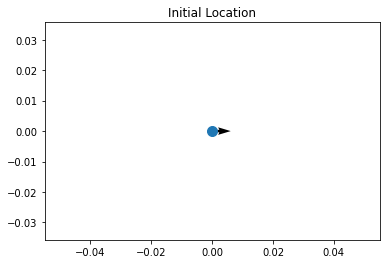

In [36]:
# course in radians, yawrate in radians/s, and speed in m/s
x_s = np.matrix([[mx[0], my[0], course[0]]]).T
u_c = np.matrix([[speed[0], yawrate[0]]]).T
#print(x, x.shape)
#print(u, u.shape)

U=float(np.cos(x_s[2])*u_c[0])
V=float(np.sin(x_s[2])*u_c[0])

# quiver plots a 2D field of arrows. X, Y define the arrow locations, U, V define the arrow directions.

plt.quiver(x_s[0], x_s[1], U, V)
plt.scatter(float(x_s[0]), float(x_s[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

In [37]:
#measurements = np.vstack((mx, my, heading))
measurements = np.vstack((mx, my))
# Lenth of the measurement
m = measurements.shape[1]
#print(measurements.shape)
#print(m)

In [38]:
# Preallocation for Plotting
x0     = []
x1     = []
x2     = []
x3     = []
x4     = []
Zx     = []
Zy     = []
Px     = []
Py     = []
Ppsi   = []
Pv     = []
Pdpsi  = []
Kx     = []
Ky     = []
Kpsi   = []
Kv     = []
Kdpsi  = [] 
dstate = []

# Para a plotagem da distância euclidiana
x0p    = [0]
x1p    = [0]
mxp    = [0]
myp    = [0]
mxGTp  = [0]
myGTp  = [0]
innov_x= []
innov_y= []

# Implementação do EKF em Python

In [39]:
class EKF():
    def __init__(self, dt):
        self.dt = dt

        self.x = None
        self.F = None
        self.u = None
        self.G = None
        
        self.Q = None
        self.M = None
        self.P = None
        
        self.h = None
        self.z = None
        self.y = None
        self.H = None
        self.R = None
        self.K = None
        self.I = np.eye(3)
        # Desvios padrões das variáveis de estado
        self.noise_pxy = 0.5*2.0*self.dt**2
        #self.noise_pxy = 0.5*8.8*self.dt**2 # erro de aleatório e bias
        self.noise_tht = 0.01*self.dt
        #self.noise_tht = 0.5*self.dt
        # Desvios padrões dos sinais de controle
        self.noise_vel = 2.0*self.dt
        #self.noise_vel = 8.8*self.dt
        ##self.noise_psi = 0.1*self.dt
        self.noise_psi = 1.5*self.dt
        # Desvios padrões das medições
        #msdGPS = 0.4862086064106338 # Devio padrão da distância euclidiana entre medição e GT
        msdGPS = 4
        self.noise_gps = msdGPS
    
    def init_dynamic_system(self, psx, psy, tht, vel, psi):
        self.x = np.matrix([[psx, psy, tht]]).T # init_state
        self.u = np.matrix([[vel, psi]]).T # init_control
        
    def set_matrices(self, tht, vel):
        f13 = float(-vel*np.sin(tht)*self.dt)
        f23 = float( vel*np.cos(tht)*self.dt)
        self.F = np.matrix([[1.0, 0.0, f13],
                            [0.0, 1.0, f23],
                            [0.0, 0.0, 1.0]])
        g11 = float(np.cos(tht))
        g21 = float(np.sin(tht))
        g32 = float(self.dt)
        self.G = np.matrix([[g11, 0.0],
                            [g21, 0.0],
                            [0.0, g32]])
        self.Q = np.diag([self.noise_pxy**2, self.noise_pxy**2, self.noise_tht**2])
        self.M = np.diag([self.noise_vel**2, self.noise_psi**2])
        self.H = np.matrix([[1.0, 0.0, 0.0],
                            [0.0, 1.0, 0.0]])
        self.R = np.diag([self.noise_gps**2, self.noise_gps**2])
        self.P = np.diag([10.0, 10.0, 10.0])
    
    def dynamic_system(self):
        x1 = self.x[0,0]+self.u[0,0]*np.cos(self.x[2,0])*self.dt
        x2 = self.x[1,0]+self.u[0,0]*np.sin(self.x[2,0])*self.dt
        x3 = self.x[2,0]+self.u[1,0]*self.dt
        self.x = np.matrix([[x1, x2, x3]]).T # state ahead
        self.u = self.u # control sign ahead
        
    def predict(self):
        f1 = self.u[0,0]*np.cos(self.x[2,0])*self.dt
        f2 = self.u[0,0]*np.sin(self.x[2,0])*self.dt
        f3 = self.u[1,0]*self.dt
        self.x = self.x + np.matrix([[f1, f2, f3]]).T
        self.P = ((self.F)*(self.P)*(self.F.T))+((self.G)*(self.M)*(self.G.T))+self.Q
        return self.x, self.P
    
    def residual(self, filterstep):
        self.h = np.matrix([[float(self.x[0,0])],
                            [float(self.x[1,0])]])
        self.z = measurements[:,filterstep].reshape((self.H).shape[0],1)
        self.y = self.z-self.h
        return self.z, self.y
    
    def update(self):
        S = (self.H)*(self.P)*(self.H).T + self.R
        self.k = ((self.P)*(self.H).T)*np.linalg.inv(S)
        self.x = self.x + (self.k)*(self.y)
        self.P = (self.I - ((self.k)*(self.H)))*self.P
        return self.k, self.x, self.P

In [40]:
ekf = EKF(dt)
ekf.init_dynamic_system(mx[0],my[0],course[0],speed[0],yawrate[0])
ekf.set_matrices(course[0],speed[0])
for filterstep in range(m):
    f,P = ekf.predict()
    z,y = ekf.residual(filterstep)
    k,f,P = ekf.update()
    
    # ===============================
    # Save states for Plotting
    # ===============================
    #print(filterstep)
    if GNSS[filterstep]:
        x0p.append(float(f[0]))
        x1p.append(float(f[1]))
        mxp.append(mx[filterstep])
        myp.append(my[filterstep])
        mxGTp.append(mxGT[filterstep])
        myGTp.append(myGT[filterstep])
    
    x0.append(float(f[0]))
    x1.append(float(f[1]))
    x2.append(float(f[2]))
    Zx.append(float(z[0]))
    Zy.append(float(z[1]))
    
    # Innovation
    innov_x.append(y[0,0])
    innov_y.append(y[1,0])
    
    # Covariance
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Ppsi.append(float(P[2,2]))
    
    # Kalman gain
    Kx.append(float(k[0,0]))
    Ky.append(float(k[1,0]))
    Kpsi.append(float(k[2,0]))

In [41]:
pos_x = np.asarray(x0)
pos_y = np.asarray(x1)
pos_mx = np.asarray(mx)
pos_my = np.asarray(my)
pos_mxGT = np.asarray(mxGT)
pos_myGT = np.asarray(myGT)

pos_xp = np.asarray(x0p)
pos_yp = np.asarray(x1p)
pos_mxp = np.asarray(mxp)
pos_myp = np.asarray(myp)
pos_mxGTp = np.asarray(mxGTp)
pos_myGTp = np.asarray(myGTp)

#print(pos_x.shape)
#print(pos_xp.shape)

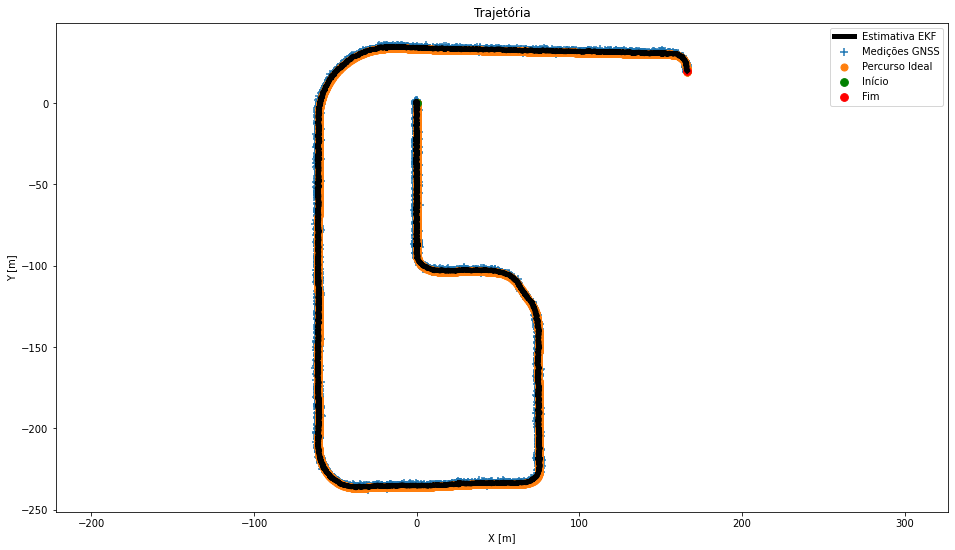

In [42]:
fig = plt.figure(figsize=(16,9))

# EKF State
plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
plt.plot(x0,x1, label='Estimativa EKF', c='k', lw=5)

# Measurements
plt.scatter(mx,my, s=50, label='Medições GNSS', marker='+')

# Ground Truth
plt.scatter(mxGT,myGT, s=50, label='Percurso Ideal', marker='o')

# Start/Goal
plt.scatter(x0[0],x1[0], s=60, label='Início', c='g')
plt.scatter(x0[-1],x1[-1], s=60, label='Fim', c='r')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Trajetória')
plt.legend(loc='best')
plt.axis('equal')

# Análise de Dados

In [43]:
# Calcular a distância euclidiana entre as estimativas e o ground truth
#de = np.sqrt((pos_x - pos_mxGT)**2 + (pos_y - pos_myGT)**2 )
dep = np.sqrt((pos_xp - pos_mxGTp)**2 + (pos_yp - pos_myGTp)**2 )

In [44]:
# Calcular a distância euclidiana entre as medições e o ground truth
#dm = np.sqrt((pos_mx - pos_mxGT)**2 + (pos_my - pos_myGT)**2 )
dmp = np.sqrt((pos_mxp - pos_mxGTp)**2 + (pos_myp - pos_myGTp)**2 )

Medição
DescribeResult(nobs=7964, minmax=(0.0, 2.9592409067301872), mean=0.9963560569833314, variance=0.2365463239094686, skewness=0.4718592618282417, kurtosis=-0.0248206667269546)
Estimação
DescribeResult(nobs=7964, minmax=(0.0, 1.6247427545233992), mean=0.740831576961437, variance=0.05275451400706338, skewness=-0.017342614982968095, kurtosis=0.07280323773852704)

Desvio Padrão da Medição
0.48636028200241493
Desvio Padrão da Estimação
0.2296835083480383


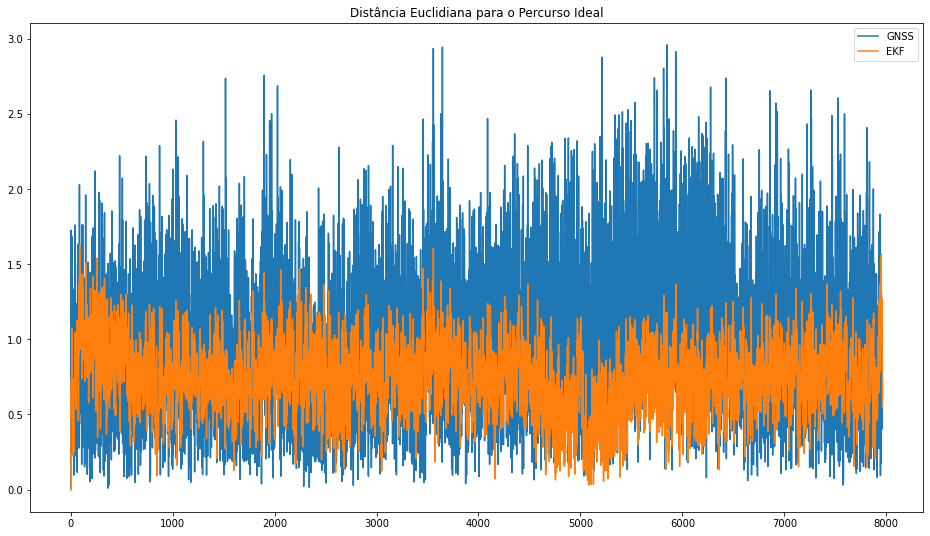

In [45]:
print("Medição")
#print(stats.describe(dm))
print(stats.describe(dmp))
print("Estimação")
#print(stats.describe(de))
print(stats.describe(dep))

# Desvio Padrão
std_GPS = stats.tstd(dmp)
std_EKF = stats.tstd(dep)
print()
print("Desvio Padrão da Medição")
print(std_GPS)
print("Desvio Padrão da Estimação")
print(std_EKF)

fig = plt.figure(figsize=(16,9))
plt.plot(dmp, label='GNSS')
plt.plot(dep, label='EKF')
plt.title("Distância Euclidiana para o Percurso Ideal")
plt.legend(loc='best')

plt.savefig('Comparação Distâncias Euclidianas para o Ground Truth.png', dpi=72, transparent=True, bbox_inches='tight')

# Gráfico com Eixos Ajustados para Análise de Dados

Medição
DescribeResult(nobs=110, minmax=(0.0, 2.0277582617158534), mean=0.84162164240495, variance=0.16023318768000894, skewness=0.305387280300593, kurtosis=-0.0074656919150339895)
Estimação
DescribeResult(nobs=110, minmax=(0.0, 1.6247427545233992), mean=0.8524968227888081, variance=0.11110812633619936, skewness=0.02782850994885711, kurtosis=-0.27159489242283286)

Desvio Padrão da Medição
0.4002913784732428
Desvio Padrão da Estimação
0.33332885614089786


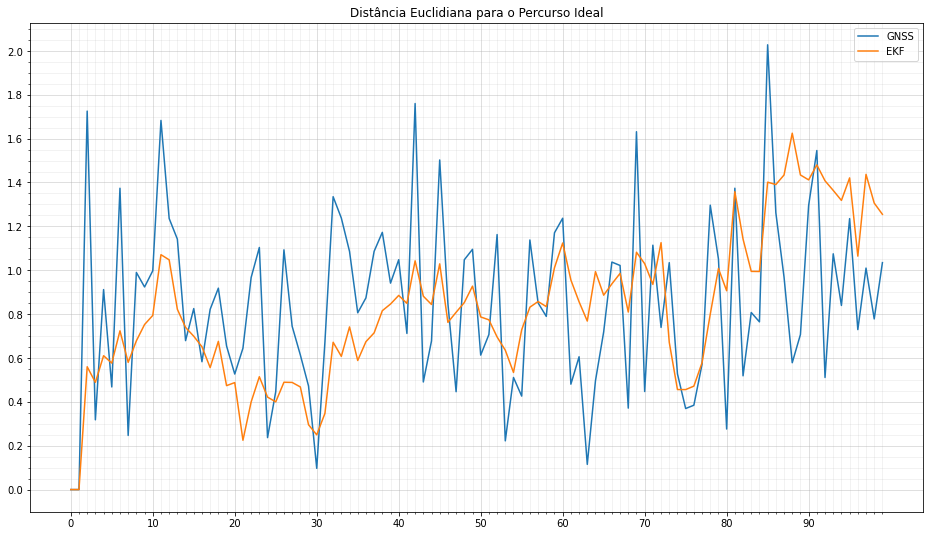

<Figure size 432x288 with 0 Axes>

In [46]:
fig = plt.figure(figsize=(16,9))

ax = fig.add_subplot(1, 1, 1)

# Major ticks every 22, minor ticks every 5
y_major_ticks = np.arange(0, 2.2, 0.2)
y_minor_ticks = np.arange(0, 2.2, 0.05)
x_major_ticks = np.arange(0, 100, 10)
x_minor_ticks = np.arange(0, 100, 1)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)


plt.plot(dmp[0:100], label='GNSS')
plt.plot(dep[0:100], label='EKF')
plt.title("Distância Euclidiana para o Percurso Ideal")
plt.legend(loc='best')
plt.figure()

print("Medição")
#print(stats.describe(dm))
print(stats.describe(dmp[0:110]))
print("Estimação")
#print(stats.describe(de))
print(stats.describe(dep[0:110]))

# Desvio Padrão
std_GPS = stats.tstd(dmp[0:110])
std_EKF = stats.tstd(dep[0:110])
print()
print("Desvio Padrão da Medição")
print(std_GPS)
print("Desvio Padrão da Estimação")
print(std_EKF)